In [1]:
#!pip install easyocr

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import easyocr
import imutils
from sklearn.model_selection import ParameterGrid
from skimage.metrics import structural_similarity as ssim

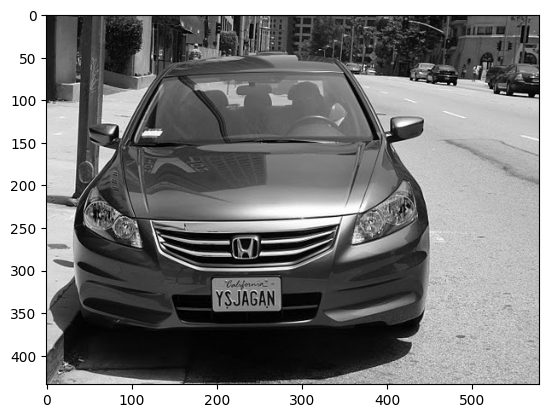

In [3]:
img= cv2.imread('car4.jpg')
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray,cv2.COLOR_BGR2RGB))

In [4]:
#to find the optimum parameters for the bilateral filter
if gray is None:
    raise ValueError("Image not found or unable to load.")

param_grid = {
    'd': [5,9,11,15],
    'sigmaColor': [15, 25, 50, 75,100],
    'sigmaSpace': [15, 25, 50, 75,100]
}


def apply_bilateral_filter(image, d, sigmaColor, sigmaSpace):
    return cv2.bilateralFilter(image, d, sigmaColor, sigmaSpace)


def compute_ssim(original, filtered):
    return ssim(original, filtered)

best_ssim = 0
best_params = None


for params in ParameterGrid(param_grid):
    filtered = apply_bilateral_filter(gray, params['d'], params['sigmaColor'], params['sigmaSpace'])
    ssim_value = compute_ssim(gray, filtered)
    
    if ssim_value > best_ssim:
        best_ssim = ssim_value
        best_params = params

print(f"Optimal Result - d: {best_params['d']}, sigmaColor: {best_params['sigmaColor']}, sigmaSpace: {best_params['sigmaSpace']}, best_ssim:{best_ssim}")


Optimal Result - d: 5, sigmaColor: 15, sigmaSpace: 15, best_ssim:0.9438095240817883


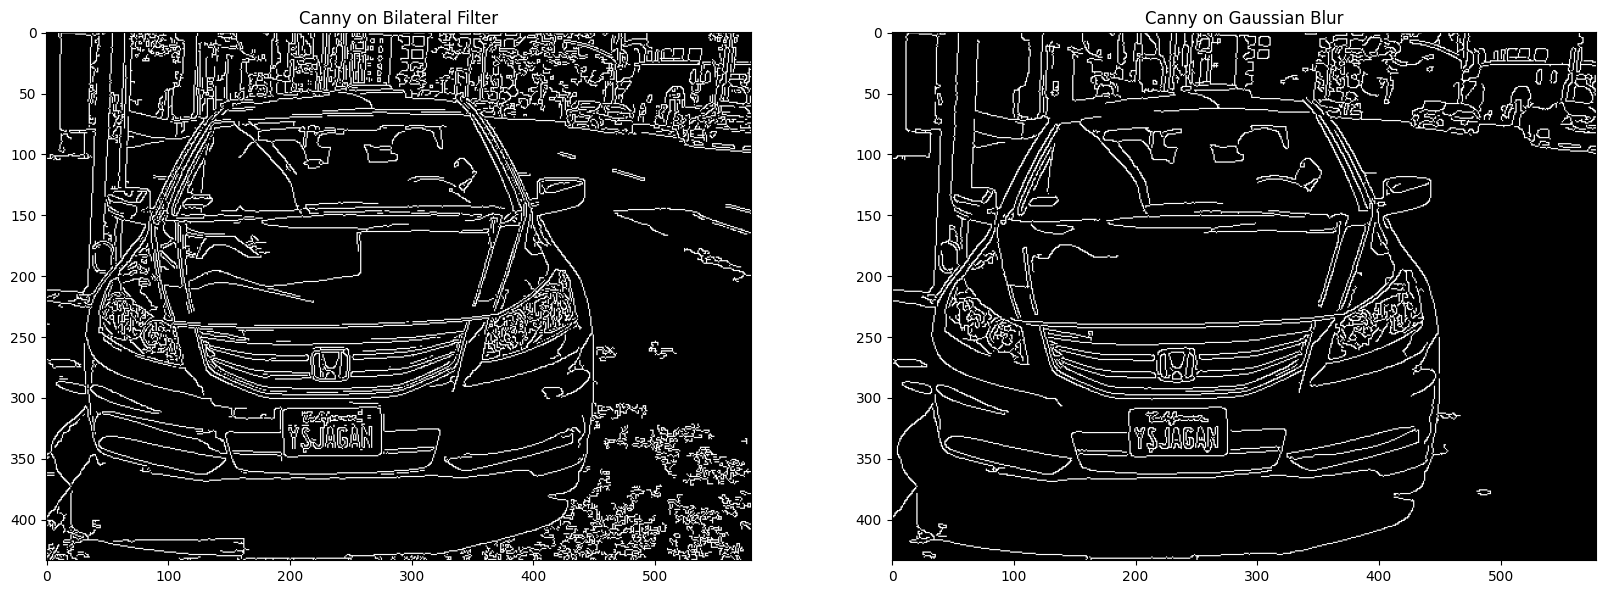

In [5]:
#noise reduction
bifilter=cv2.bilateralFilter(gray,5,15,15) 
gauss_blur = cv2.GaussianBlur(gray, (5, 5), 0)

#edge detection
edged1=cv2.Canny(bifilter,30,200) 
edged2=cv2.Canny(gauss_blur,30,200) 

# Plotting the images
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.title('Canny on Bilateral Filter')
plt.imshow(cv2.cvtColor(edged1, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title('Canny on Gaussian Blur')
plt.imshow(cv2.cvtColor(edged2, cv2.COLOR_BGR2RGB))

plt.show()

[[[274 310]]

 [[272 348]]

 [[195 346]]

 [[198 309]]]


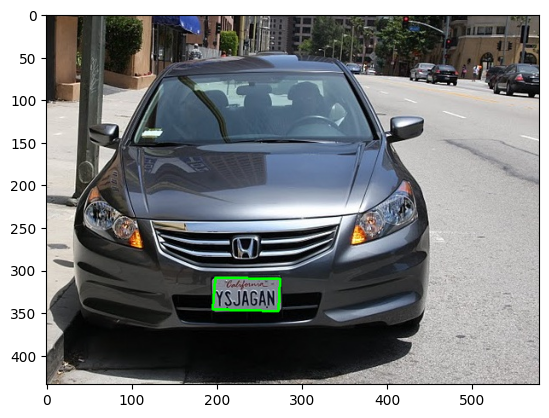

In [6]:
points=cv2.findContours(edged1.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
contours=imutils.grab_contours(points)
contours=sorted(contours,key=cv2.contourArea,reverse=True)[:10]

numberplate=None
for contour in contours:
    approx=cv2.approxPolyDP(contour,5,True)
    if len(approx)==4:
        numberplate=approx
        break

print(numberplate)

coordinates=np.array(numberplate)
numberplate=coordinates.reshape((-1,1,2))
cv2.polylines(img,[numberplate],isClosed=True,color=(0,255,0),thickness=2)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

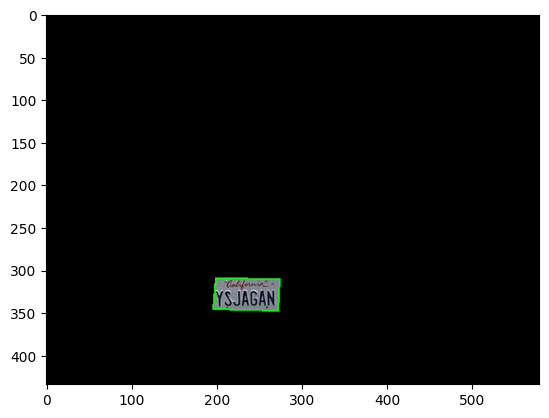

In [7]:
mask=np.zeros(gray.shape,np.uint8)
new_img=cv2.drawContours(mask,[numberplate],0,255,-1)
new_img=cv2.bitwise_and(img,img,mask=mask)
plt.imshow(cv2.cvtColor(new_img,cv2.COLOR_BGR2RGB))

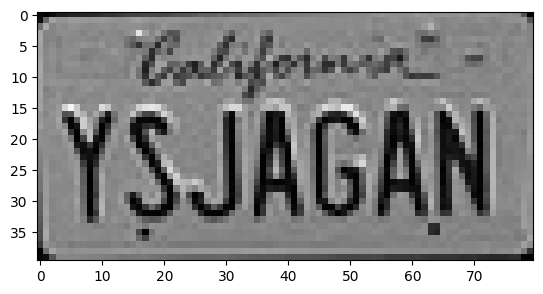

In [13]:
(x,y)=np.where(mask==255)
x1,y1=np.min(x),np.min(y)
x2,y2=np.max(x),np.max(y)
cropped_img=gray[x1:x2+1,y1:y2+1]
plt.imshow(cv2.cvtColor(cropped_img,cv2.COLOR_BGR2RGB))

In [20]:
reader=easyocr.Reader(['en'])
# Convert the image to grayscale if it has 3 channels
if len(cropped_img.shape) == 3 and cropped_img.shape[2] == 3:
    gray = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
elif len(cropped_img.shape) == 2:
    gray = cropped_img
else:
    raise ValueError("Unexpected number of channels in the image.")

# Apply thresholding
binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
# Optionally, use morphological operations to clean up the text
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
result = reader.readtext(binary)
for (bbox, text, prob) in result:
    print(f"Detected text: {text} (Confidence: {prob:.2f})")

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


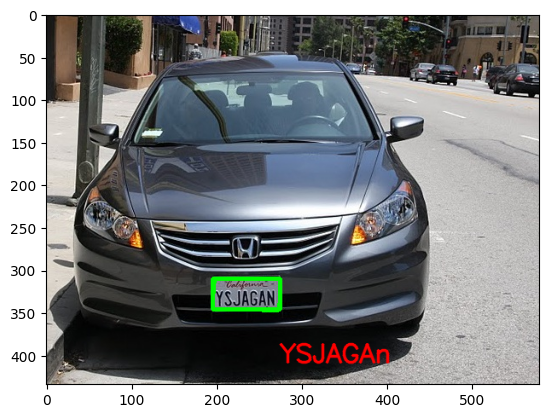

In [10]:
text=result[0][-2]
font= cv2.FONT_HERSHEY_SIMPLEX
res=cv2.putText(img,text=text,org=(approx[0][0][0],approx[1][0][1]+60),fontFace=font,fontScale=1,color=(0,0,255),thickness=2,lineType=cv2.LINE_AA)
res=cv2.rectangle(img,tuple(approx[0][0]),tuple(approx[2][0]),(0,255,0),3)
plt.imshow(cv2.cvtColor(res,cv2.COLOR_BGR2RGB))
